# Méthodes de recherche linéaire

Considérons $f \in C^2$.  Une méthode de descente consiste à calculer itérativement
$$
x_{k+1} = x_k + \alpha^* d_k
$$
où $\alpha^*$ minimise approximativement $f(x_k - \alpha d_k)$.

In [1]:
using Optim
using Plots

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


Plusieurs techniques de recherche linéaire sont proposées en Julia, comme expliqué à la page https://github.com/JuliaNLSolvers/LineSearches.jl

Considérons à nouveau l'exemple de Rosenbrock, dont l'expression mathématique est

$$
f(x,y) = (1-x)^2 + 100(y-x^2)^2
$$

Son gradient peut être calculé comme

$$
\nabla f(x,y) =
\begin{pmatrix}
-2(1-x)-400x(y-x^2) \\
200(y-x^2)
\end{pmatrix}
$$

$$
\nabla^2 f(x,y) =
\begin{pmatrix}
2 - 400(y-x^2) + 800x^2 & -400x \\
-400x & 200
\end{pmatrix}
=
\begin{pmatrix}
2 - 400y + 1200x^2 & -400x \\
-400x & 200
\end{pmatrix}
$$

Le minimiseur est situé en $(1,1)$. En effet,
$$
\nabla f(1,1) = \begin{pmatrix} 0 \\ 0 \end{pmatrix}
$$
et
$$
\nabla^2 f(1,1) =
\begin{pmatrix}
802 & -400 \\ -400 & 200
\end{pmatrix}
$$
Les déterminants des mineurs principaux sont positifs comme ils valent respectivement 802 et $802\times200-400^2= 400$, aussi la matrice hessienne est définie positive.

In [2]:
# Rosenbrock function
# Source: https://bitbucket.org/lurk3r/optim.jl

function rosenbrock(x::Vector)
    return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end

function rosenbrock_gradient!(storage::Vector, x::Vector)
    storage[1] = -2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1]
    storage[2] = 200.0 * (x[2] - x[1]^2)
end

function rosenbrock_hessian!(storage::Matrix, x::Vector)
    storage[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
    storage[1, 2] = -400.0 * x[1]
    storage[2, 1] = -400.0 * x[1]
    storage[2, 2] = 200.0
end

rosenbrock_hessian! (generic function with 1 method)

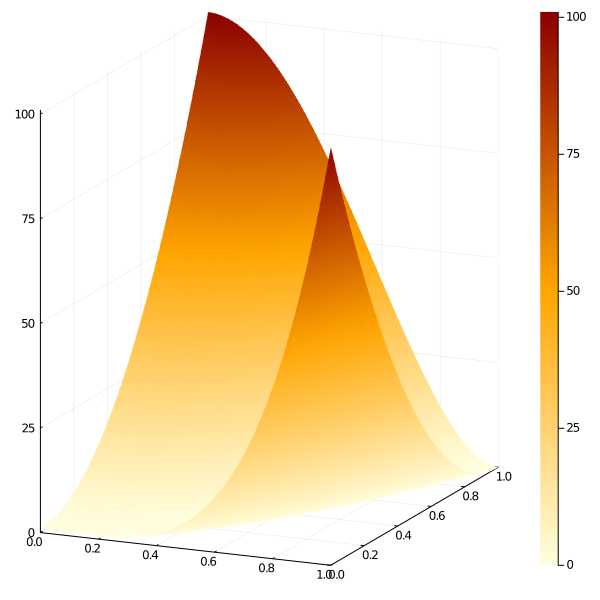

In [3]:
using Plots

default(size=(600,600), fc=:heat)
x, y = 0:0.02:1.0, 0:0.02:1.0
z = Surface((x,y)->rosenbrock([x,y]), x, y)
surface(x,y,z, linealpha = 0.3)

In [4]:
Plots.contour(x,y,z, linealpha = 0.1, levels=1600)

Nous pouvons résoudre le problème d'optimisation avec la fonction `optimize` présente dans la librairie `Optim.jl`:

In [ ]:
res = optimize(rosenbrock, rosenbrock_gradient!,
               [20.0, 20.0],
               Optim.GradientDescent(),
               Optim.Options(g_tol = 1e-12,
                             store_trace = true,
                             show_trace = true))

In [ ]:
res = optimize(rosenbrock, rosenbrock_gradient!,
               [20.0, 20.0],
               Optim.BFGS(),
               Optim.Options(g_tol = 1e-12,
                             store_trace = true,
                             show_trace = true))

In [ ]:
using BenchmarkTools

@btime res = optimize(rosenbrock, rosenbrock_gradient!,
                   [0.0, 0.0], Optim.BFGS(),
               Optim.Options(g_tol = 1e-12,
                             store_trace = true,
                             show_trace = false))

In [ ]:
iter = Optim.trace(res)

## Différentiation en Julia

Calculer le gradient et la matrice hessienne est souvent ardu, et même pour des fonctions simples, cela peut s'avérer une tâche pénible. Afin d'alléger ce coût, il est possible d'utiliser des dérivées numériques ou la différentiation automatique.

### Dérivées numériques

Des fonctions de dérivation numérique sont fournies dans la librairie `Calculus`, comme illustré ci-dessous.

In [ ]:
using Calculus, LinearAlgebra
rg = Calculus.gradient(rosenbrock)

Évaluons la fonction de gradient, nouvellement construite, à la solution [1,1].

In [ ]:
gsol = rg([1,1])

Nous sommes proches de zéro, mais il y a des erreurs d'approximation, lesquelles peuvent empêcher la convergence vers une solution correcte, ou, à tout le mois, nuire à la precision de la solution, comme

In [ ]:
norm(gsol)

In [ ]:
storage = [0.0,0.0]
function rg!(storage::Vector, x::Vector)
    s = rg(x)
    storage[1:length(s)] = s[1:length(s)]
end

In [ ]:
storage

In [ ]:
@btime res = optimize(rosenbrock, rg!,
               [0.0, 0.0],
               Optim.BFGS(),
               Optim.Options(g_tol = 1e-12,
                             store_trace = true,
                             show_trace = false))

### Différentiation automatique

In [ ]:
using ForwardDiff

g = x -> ForwardDiff.gradient(rosenbrock, x);
H = x -> ForwardDiff.hessian(rosenbrock, x)

function g!(storage::Vector, x::Vector)
    s = g(x)
    storage[1:length(s)] = s[1:length(s)]
end

In [ ]:
g([1.0,1.0])

In [ ]:
res = optimize(rosenbrock, g!,
               [0.0, 0.0],
               Optim.BFGS(),
               Optim.Options(g_tol = 1e-12,
                             store_trace = true,
                             show_trace = false))

In [ ]:
@btime res = optimize(rosenbrock, g!,
               [0.0, 0.0],
               Optim.BFGS(),
               Optim.Options(g_tol = 1e-12,
                             store_trace = true,
                             show_trace = false))

## Méthode de Newton

$$
x_{k+1} = x_k-\nabla^2 f(x_k)^{-1} \nabla f(x_k)
$$
ou
$$
\nabla^2 f(x_k) x_{k+1} = \nabla^2 f(x_k) x_k- \nabla f(x_k)
$$


In [ ]:
function Newton(f::Function, g::Function, h:: Function,
        xstart::Vector, verbose::Bool = false,
        δ::Float64 = 1e-6, nmax::Int64 = 1000)

    k = 1
    x = xstart
    n = length(x)
    δ2 = δ*δ
    H = zeros(n,n)+I
    dfx = ones(n)
    
    if (verbose)
        fx = f(x)
        println("$k. x = $x, f(x) = $fx")
    end

    g(dfx, x)

    while (dot(dfx,dfx) > δ2 && k <= nmax)
        k += 1
        g(dfx,x)
        h(H,x)
        # Hs = dfx, x_{k+1} = x_k - s
        x -= H\dfx  # x = x - s
        if (verbose)
            fx = f(x)
            println("$k. x = $x, f(x) = $fx ")
        end
    end
end

In [ ]:
Newton(rosenbrock, rosenbrock_gradient!, rosenbrock_hessian!, [-100.0,100.0], true)

## Implémentation d'un algorithme de recherche linéaire

Un squelette très basique d'implémentation de recherche linéaire suit.

In [ ]:
function ls(f::Function, g::Function, h:: Function,
        x0::Vector,
        direction::Function, steplength::Function,
        δ::Float64 = 1e-8, nmax::Int64 = 1000)

    k = 0
    x = x0
    δ2 = δ*δ
    n = length(x)

    dfx = ones(n)

    g(dfx, x)

#    println("$k. $x")

    while (dot(dfx,dfx) > δ2 && k <= nmax)
        # Compute the search direction
        d, dfx = direction(f,g,h,x)
        # Compute the step length along d
        α = steplength(f,dfx,x,d)
        # Update the iterate
        x += α*d
        k += 1
#        println("$k. $x")
    end
end

In [ ]:
constantStep(f::Function, dfx:: Vector, x:: Vector, d::Vector) = 1

In [ ]:
function direction(f::Function, g:: Function, h:: Function, x::Vector)
    n = length(x)
    df = ones(n)
    H = zeros(n,n)+I
    g(df,x)
    h(H,x)
    return -H\df, df
end

In [ ]:
ls(rosenbrock, rosenbrock_gradient!, rosenbrock_hessian!,
    [0.0,0.0], direction, constantStep)

In [ ]:
function ArmijoStep(f::Function, dfx::Vector, x::Vector, d:: Vector,
    αmax:: Float64 = 1.0, β:: Float64 =0.1, κ:: Float64 =0.2)
    
    s = β*dot(dfx,d)
    α = αmax
    
    fx = f(x)
    fxcand = f(x+α*d)
    
    while (fxcand >= fx+α*s)
        α *= κ
        fxcand = f(x+α*d)        
    end
    
    return α
end

In [ ]:
@btime ls(rosenbrock, rosenbrock_gradient!, rosenbrock_hessian!,
          [0.0,0.0], direction, ArmijoStep)

In [ ]:
function direction3(f::Function, g:: Function, h:: Function, x::Vector)
    n = length(x)
    df = ones(n)
    H = zeros(n,n)+I
    g(df,x)
    h(H,x)
    H[1,2] = H[2,1]= 0.0
    return -H\df, df
end

In [ ]:
ls(rosenbrock, rosenbrock_gradient!, rosenbrock_hessian!,
    [0.0,0.0], direction3, ArmijoStep)

## Approximations de matrice hessienne

### Mise à jour BFGS

En supposant que $B_k$ est une matrice symétrique définie positive, la mise à jour BFGS est définie comme
$$
B_{k+1} = B_k - \frac{B_ks_ks_k^T B_k}{s_k^T B_k s_k} + \frac{y_ky_k^T}{s_k^Ty_k}
$$
où $y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$ and $s_k = x_{k+1} - x_k$.
Son implémentation de Julia est directe.

In [ ]:
function BFGSUpdate(B, y, s)
    Bs = B*s
    return B - (Bs*Bs')/dot(s, Bs) + (y*y')/dot(s,y)
end

In [ ]:
function BFGSUpdate!(B, y, s)
    Bs = B*s
    B[:,:] = B - (Bs*Bs')/dot(s, Bs) + (y*y')/dot(s,y)
end

In [ ]:
n = 3
y = [ 1.0 2 3]'
s = [ 0.5 0.5 0.5 ]'

In [ ]:
B = zeros(n,n)+I
BFGSUpdate(B, y, s)

In [ ]:
B

In [ ]:
BFGSUpdate!(B, y, s)
B

Il est cependant souvent plus intéressant de travailler avec l'inverse de la matrice hessienne. Une dérivation technique donne
$$
B_{k+1}^{-1} = \left(I - \frac{s_ky_k^T}{s_k^T y_k} \right) B_k^{-1} \left( I - \frac{y_ks_k^T}{y_k^Ts_k} \right) + \frac{s_k s_k^T}{y_k^Ts_k}
$$
L'implémentation Julia correspondante suit.

In [ ]:
function InvBFGSUpdate_naive(invB::Matrix, y::Vector, s::Vector)
    ys = dot(y, s)
    A = I-(s*y')/ys
    return A*invB*A' + (s*s')/ys         
end

Cette implémentation est cependant inefficace comme elle implique une matrice temporaire. Nous pourrions l'éviter en réorganisant les termes, considérant que $B_{k}^{-1}$ est symétrique, et que $y_{k}^{T}B_k^{-1}y_k$ ainsi que $s_k^Ty_k$ sont des scalaires. Ceci conduit à
$$
B_{k+1}^{-1} = B_{k}^{-1} + \frac{(s_k^Ty_k+y_k^TB_{k}^{-1}y_k)s_ks_k^T}{(s_k^Ty_k)^2} -
\frac{B_k^{-1}y_ks_k^T + s_ky_k^TB_k^{-1}}{s_k^Ty_k}
$$
L'implémentation Julia correspondante est

In [ ]:
function InvBFGSUpdate(invB::Matrix, y::Vector, s::Vector)
    ys = dot(y, s)
    invBy = invB*y
    return invB+1.0/ys*((ys+dot(y, invBy))/ys*(s*s') - invBy*s' - s*invBy')
end

### Illustration

In [ ]:
n = 2
B = invB = zeros(n,n)+I
n, m = size(B)

s = [-1.75,-0.75]
y = [-8.5,-5.0]

Bp = BFGSUpdate(B, y, s)

In [ ]:
inv(Bp)

In [ ]:
invBp = InvBFGSUpdate_naive(invB, y, s)

In [ ]:
invBp = InvBFGSUpdate(invB, y, s)

In [ ]:
using BenchmarkTools

In [ ]:
@btime InvBFGSUpdate_naive(invB, y, s)

In [ ]:
@btime InvBFGSUpdate(invB, y, s)

In [ ]:
n = 1000
B = invB = zeros(n,n)+I
n, m = size(B)
s = rand(n)
y = 10 * rand(n)

A1 = InvBFGSUpdate_naive(invB, y, s)

@btime InvBFGSUpdate_naive(invB, y, s)

In [ ]:
A2 = InvBFGSUpdate(invB, y, s)

@btime InvBFGSUpdate(invB, y, s)

In [ ]:
norm(A1-A2)

### Mise à jour SR1

Adapté de https://en.wikipedia.org/wiki/Symmetric_rank-one

$$
B_{k+1} = B_{k} + {\frac {(y_{k}-B_{k}s_{k})(y_{k}-B_{k}s_{k})^{T}}{(y_{k}-B_{k}s_{k})^{T}s_k}},
$$
où $y_k = \nabla f(x_{\rm cand}) - \nabla f(x_k)$ et $s_k = x_{\rm cand} - x_k$.

Ici $B_k$ n'est pas nécessairement définie positive.

Le mise à jour correspondante de l'approximation  de l'inverse de la matrice hessienne, $H_{k}=B_{k}^{-1}$, est
$$
H_{k+1}=H_{k}+{\frac{(s_{k}-H_{k}y_{k})(s_{k}-H_{k}y_{k})^{T}}{(s_{k}-H_{k}y_{k})^{T}y_{k}}}.
$$
La formule SR1 a été redécouverte à diverses reprises. Un inconvénient est que le dénominateur peut s'annuler ou être réduit à une quantité négligeable. Certains auteurs suggèrent que la mise à jour ne soit appliqués que si
$$
|s_{k}^{T}(y_{k}-B_{k}s_{k})|\geq r\|s_{k}\|\|y_{k}-B_{k}s_{k}\|,
$$
où $r \in (0,1)$ est un nombre petit, e.g. $10^{-8}$.